In [1]:
import numpy as np
import corner as DFM
import desispec.io as desiIO
from astropy.table import Table
# --- fomospec ---
from fomospec import util as UT
from fomospec import catalog as Cat
from fomospec import fitters as Fitters

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
prosp = Fitters.Prospector()

In [4]:
lgal = Cat.LGal()

In [5]:
galid = 1

In [6]:
source, meta = lgal.Spectra(galid, type='source')
desibgs, _ = lgal.Spectra(galid, type='desibgs')

In [11]:
zred = meta['REDSHIFT']


(0.0, 15.0)

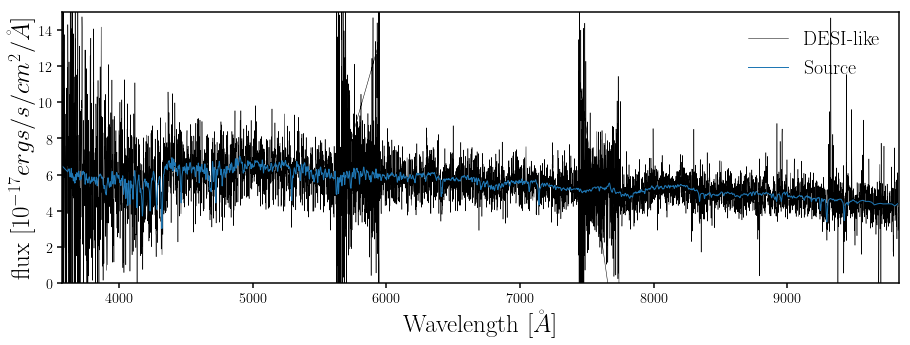

In [7]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(desibgs['wave'], desibgs['flux'], c='k', lw=0.5, label='DESI-like')
sub.plot(source['wave'], source['flux'], c='C0', lw=1, label='Source')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel('Wavelength [$\AA$]', fontsize=25)
sub.set_xlim([desibgs['wave'].min(), desibgs['wave'].max()])
sub.set_ylabel('flux [$10^{-17} ergs/s/cm^2/\AA$]', fontsize=25)
sub.set_ylim([0., 15.])

Read in emcee output

In [8]:
chain, lnp = lgal.SpecFit(galid, type='desibgs', fit='prospector_mcmc', masked=True)

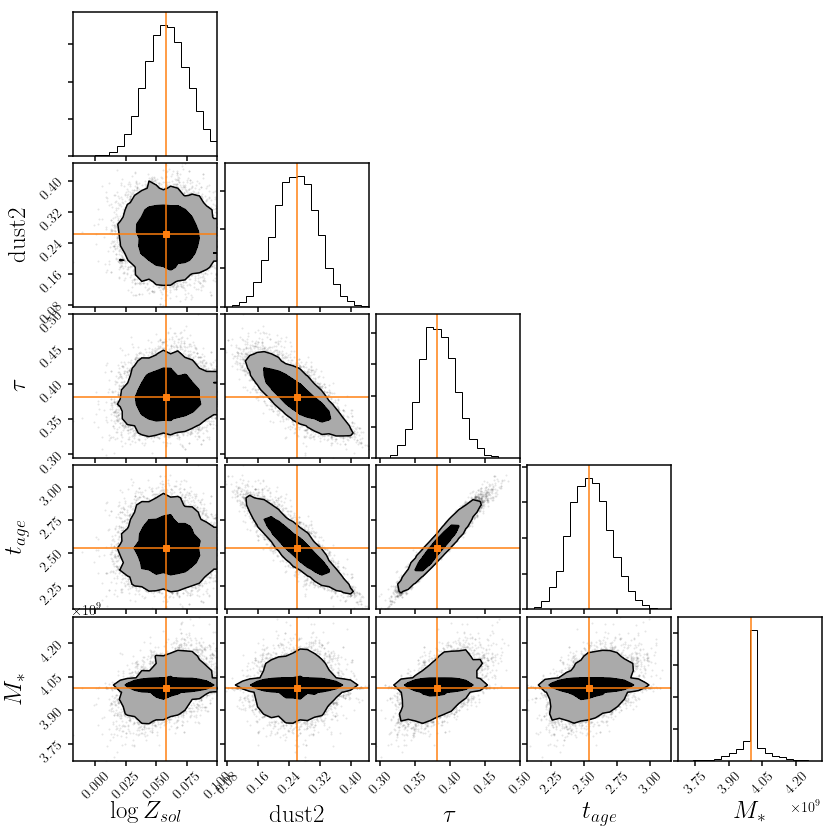

In [12]:
imax = np.argmax(lnp)
i, j = np.unravel_index(imax, lnp.shape)

chain_thin = chain[:,::5,:]
chain_flat = chain_thin.reshape(chain_thin.shape[0] * chain_thin.shape[1], chain_thin.shape[2])

fig = DFM.corner(chain_flat, truths=chain[i,j,:], truth_color='C1', 
                 labels=[r'$\log Z_{sol}$', 'dust2', r'$\tau$', '$t_{age}$', '$M_*$'], 
                 label_kwargs={'fontsize': 25},
                 fill_contours=True, levels=[0.68, 0.95])
tt_map_d = chain[i,j,:]
flux_map, _, _ = prosp.model(desibgs['wave'], tt_map_d, zred)

(0.0, 15.0)

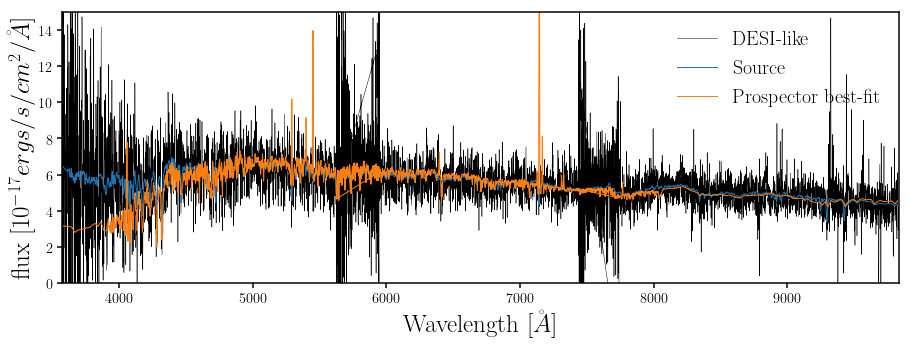

In [14]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(desibgs['wave'], desibgs['flux'], c='k', lw=0.5, label='DESI-like')
sub.plot(source['wave'], source['flux'], c='C0', lw=1, label='Source')
sub.plot(desibgs['wave'], flux_map, c='C1', lw=1, label='Prospector best-fit')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel('Wavelength [$\AA$]', fontsize=25)
sub.set_xlim([desibgs['wave'].min(), desibgs['wave'].max()])
sub.set_ylabel('flux [$10^{-17} ergs/s/cm^2/\AA$]', fontsize=25)
sub.set_ylim([0., 15.])

(2.0, 8.0)

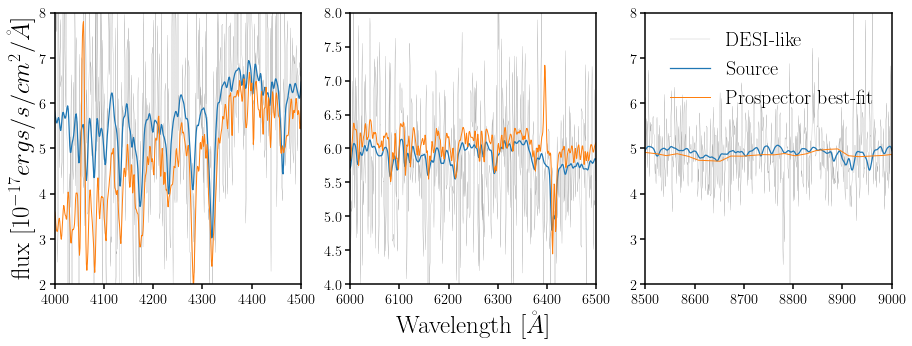

In [16]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.plot(desibgs['wave'], desibgs['flux'], c='k', lw=0.1, label='DESI-like')
sub.plot(source['wave'], source['flux'], c='C0', lw=1.25, label='Source')
sub.plot(desibgs['wave'], flux_map, c='C1', lw=1, label='Prospector best-fit')
sub.set_xlim([4e3, 4.5e3])
sub.set_ylabel('flux [$10^{-17} ergs/s/cm^2/\AA$]', fontsize=25)
sub.set_ylim([2., 8.])

sub = fig.add_subplot(132)
sub.plot(desibgs['wave'], desibgs['flux'], c='k', lw=0.1, label='DESI-like')
sub.plot(source['wave'], source['flux'], c='C0', lw=1.25, label='Source')
sub.plot(desibgs['wave'], flux_map, c='C1', lw=1, label='Prospector best-fit')
sub.set_xlabel('Wavelength [$\AA$]', fontsize=25)
sub.set_xlim([6e3, 6.5e3])
sub.set_ylim([4., 8.])

sub = fig.add_subplot(133)
sub.plot(desibgs['wave'], desibgs['flux'], c='k', lw=0.1, label='DESI-like')
sub.plot(source['wave'], source['flux'], c='C0', lw=1.25, label='Source')
sub.plot(desibgs['wave'], flux_map, c='C1', lw=1, label='Prospector best-fit')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlim([8.5e3, 9e3])
sub.set_ylim([2., 8.])

In [17]:
gal_input = lgal.GalInput(galid)

(0.0, 0.04)

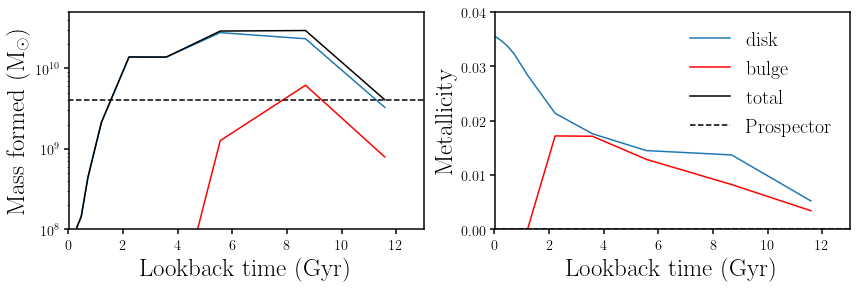

In [18]:
fig = plt.figure(figsize=(14,4))
sub = fig.add_subplot(121)
sub.plot(gal_input['sfh_t'], gal_input['sfh_disk'], color='C0')
sub.plot(gal_input['sfh_t'], gal_input['sfh_bulge'], color='red')
sub.plot(gal_input['sfh_t'], gal_input['sfh_bulge'] + gal_input['sfh_disk'], color='black', label='total')
mmed = np.percentile(chain_flat[:,4], [50])
sub.plot([0., 15.], [mmed, mmed], c='k', ls='--', label='Prospector')
#sub.legend(loc='lower right', fontsize=20)
sub.set_xlabel('Lookback time (Gyr)', fontsize=25)
sub.set_xlim([1e-2, 13.])
sub.set_ylabel(r'Mass formed (M$_\odot$)', fontsize=25)
sub.set_yscale('log')
sub.set_ylim([1e8, 5e10])

sub = fig.add_subplot(122) 
sub.plot(gal_input['sfh_t'], gal_input['Z_disk'], label='disk')
sub.plot(gal_input['sfh_t'], gal_input['Z_bulge'], color='red', label='bulge')
sub.plot([0., 0.], [0., 0.], c='k', ls='-', label='total')
sub.plot([0., 15.], [0., 0.], c='k', ls='--', label='Prospector')
sub.legend(fontsize=20)
sub.set_xlabel('Lookback time (Gyr)', fontsize=25)
sub.set_xlim([1e-2, 13.])
sub.set_ylabel('Metallicity', fontsize=25)
sub.set_ylim([0., 0.04])